#**GOOG Forecasting using InfoNCE & stochastic interpolants**

**Pre-Processing & Feature Engineering**

In [ ]:
# Install yahoo finance package for real data
!pip install yfinance

In [ ]:
# Import libs
import math
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [ ]:
df = yf.download('GOOG',start='2004-08-19')
#Open-High-Close-Low Avg
df['OHCL'] = df[['Open','High','Low','Close']].mean(axis=1)
#Simple Moving Avg - 20 Days,50 Days
df['SMA20'] = df['Close','GOOG'].rolling(window=20).mean()
df['SMA50'] = df['Close','GOOG'].rolling(window=50).mean()
#Historic Volatility over 1 Trading Year
df['Volatility'] = df['Close','GOOG'].pct_change().rolling(21).std() * math.sqrt(252)
#Percentile Rank
df['Pc_Rank'] = df['Close','GOOG'].rolling(21).rank(pct=True)
print(len(df))
df = df.dropna(axis=0)
df

/tmp/ipython-input-2148412764.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('GOOG',start='2004-08-19')
[*********************100%***********************]  1 of 1 completed

5361


Price,Close,High,Low,Open,Volume,OHCL,SMA20,SMA50,Volatility,Pc_Rank
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,,,,,
Date,,,,,,,,,,
2004-10-28,4.781731,4.808694,4.591253,4.617969,596097978,4.699912,3.744259,3.142802,0.688158,1.000000
2004-10-29,4.715930,4.946235,4.714941,4.920013,849672890,4.824280,3.816072,3.187478,0.689603,0.952381
2004-11-01,4.849265,4.889834,4.731515,4.787916,490828877,4.814633,3.891484,3.230877,0.690192,1.000000
2004-11-02,4.820570,4.928919,4.782722,4.917293,455553149,4.862376,3.961367,3.273163,0.695864,0.952381
2004-11-03,4.741409,4.987051,4.718651,4.902450,557630330,4.837390,4.028887,3.316107,0.705769,0.857143
...,...,...,...,...,...,...,...,...,...,...
2025-12-02,316.019989,318.600006,314.220001,316.899994,24668200,316.434998,296.026999,270.985999,0.372369,0.809524
2025-12-03,320.619995,322.040009,314.279999,316.029999,32285100,318.242500,298.154999,272.351599,0.373552,0.952381


**EDA**

<Axes: xlabel='Date'>

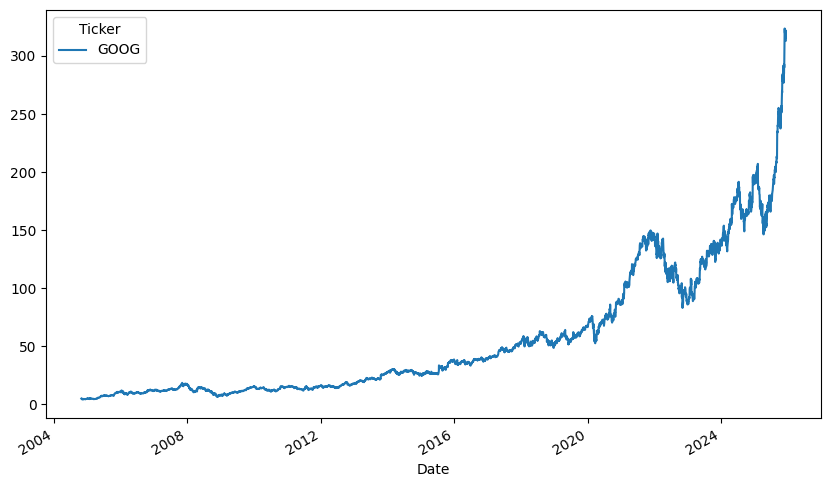

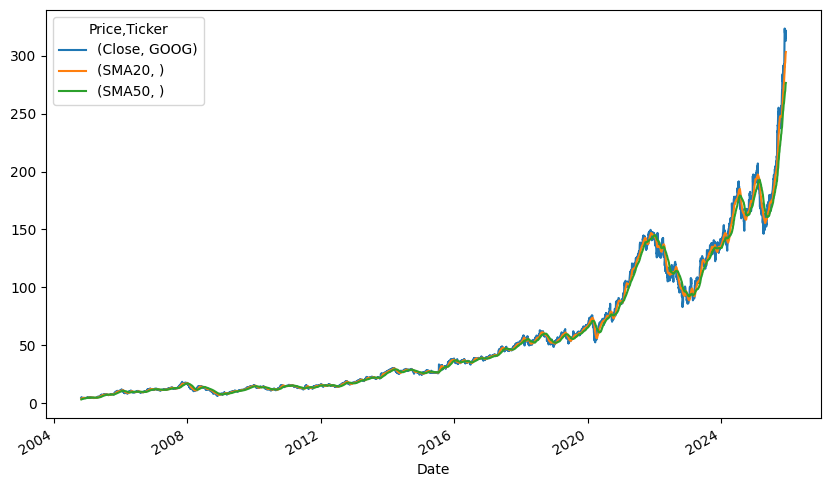

In [ ]:
# Data Smoothing
df['Close'].plot(figsize=(10, 6))
df[['Close','SMA20','SMA50']].plot(figsize=(10, 6))

**Stochastic Interpolants & NCE**

> Add blockquote



In [ ]:
#Recurrent Stochastic Interpolants
#NORMALIZE FEATURES
feature_cols = ["Close", "OHCL", "SMA20", "SMA50", "Volatility", "Pc_Rank"]
X = df[feature_cols].values.astype("float32")           # (T, D)
means = X.mean(axis=0)
stds = X.std(axis=0)
X_norm = (X - means) / stds

# Close (normalized) as 1D target series
y_series = X_norm[:, 0].astype("float32")               # (T,)


class TSDataset(Dataset):
    def __init__(self, X, y, context_len=60):
        self.X = torch.from_numpy(X).float()            # (T, D)
        self.y = torch.from_numpy(y).float().unsqueeze(-1)  # (T, 1)
        self.C = context_len

    def __len__(self):
        return len(self.X) - self.C

    def __getitem__(self, idx):
        # context features (C, D)
        context = self.X[idx : idx + self.C]
        # scalar targets for interpolant loss
        x_t   = self.y[idx + self.C - 1]    # y_t
        x_tp1 = self.y[idx + self.C]        # y_{t+1}
        return context, x_t, x_tp1


context_len = 60
full_ds = TSDataset(X_norm, y_series, context_len)

train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

In [ ]:
#NORMALIZE FEATURES
feature_cols = ["Close", "OHCL", "SMA20", "SMA50", "Volatility", "Pc_Rank"]
X = df[feature_cols].values.astype("float32")           # (T, D)
means = X.mean(axis=0)
stds = X.std(axis=0)
X_norm = (X - means) / stds

# Close (normalized) as 1D target series
y_series = X_norm[:, 0].astype("float32")               # (T,)


class TSDataset(Dataset):
    def __init__(self, X, y, context_len=60):
        self.X = torch.from_numpy(X).float()            # (T, D)
        self.y = torch.from_numpy(y).float().unsqueeze(-1)  # (T, 1)
        self.C = context_len

    def __len__(self):
        return len(self.X) - self.C

    def __getitem__(self, idx):
        # context features (C, D)
        context = self.X[idx : idx + self.C]
        # scalar targets for interpolant loss
        x_t   = self.y[idx + self.C - 1]    # y_t
        x_tp1 = self.y[idx + self.C]        # y_{t+1}
        return context, x_t, x_tp1


context_len = 60
full_ds = TSDataset(X_norm, y_series, context_len)

train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)


In [ ]:
#SCHEDULES
def alpha(s):      # (B,1)
    return 1.0 - s

def beta(s):
    return s

def gamma(s, sigma=1.0):
    return sigma * torch.sqrt(s * (1.0 - s))

def alpha_dot(s):
    return -torch.ones_like(s)

def beta_dot(s):
    return torch.ones_like(s)

def gamma_dot(s, sigma=1.0):
    eps = 1e-6
    s = torch.clamp(s, eps, 1 - eps)
    num = (1.0 - 2.0 * s)
    den = 2.0 * torch.sqrt(s * (1.0 - s))
    return sigma * num / den


#MODELS
D_feat = X_norm.shape[1]
h_dim  = 32

class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

    def forward(self, context):
        # context: (B, C, D_feat)
        out, (h, c) = self.lstm(context)
        return out[:, -1, :]         # (B, hidden_dim)


class VelocityNet(nn.Module):
    def __init__(self, h_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1 + 1 + h_dim, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 1),
        )

    def forward(self, s, x_s, h_t):
        # s: (B,1), x_s:(B,1), h_t:(B,h_dim)
        inp = torch.cat([s, x_s, h_t], dim=-1)
        return self.net(inp)


class ScoreNet(nn.Module):
    def __init__(self, h_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1 + 1 + h_dim, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 1),
        )

    def forward(self, s, x_s, h_t):
        inp = torch.cat([s, x_s, h_t], dim=-1)
        return self.net(inp)


# forecasting head from h_t -> next y
class ForecastHead(nn.Module):
    def __init__(self, h_dim):
        super().__init__()
        self.fc = nn.Linear(h_dim, 1)

    def forward(self, h_t):
        return self.fc(h_t)


encoder   = RNNEncoder(D_feat, h_dim).to(device)
vel_net   = VelocityNet(h_dim).to(device)
score_net = ScoreNet(h_dim).to(device)
f_head    = ForecastHead(h_dim).to(device)

params = list(encoder.parameters()) + list(vel_net.parameters()) \
         + list(score_net.parameters()) + list(f_head.parameters())
opt = torch.optim.Adam(params, lr=1e-3)

beta_dist = torch.distributions.Beta(0.1, 0.1)
mse = nn.MSELoss()


In [ ]:
def train_one_epoch(loader):
    encoder.train(); vel_net.train(); score_net.train(); f_head.train()
    total_loss = 0.0
    for context, x_t, x_tp1 in loader:
        context = context.to(device)             # (B,C,D)
        x_t     = x_t.to(device)                 # (B,1)
        x_tp1   = x_tp1.to(device)               # (B,1)
        B = x_t.size(0)

        # s ~ Beta, z ~ N(0,1)
        s = beta_dist.sample((B, 1)).to(device)
        z = torch.randn_like(x_t)

        # schedules
        a  = alpha(s)
        b  = beta(s)
        g  = gamma(s)
        ad = alpha_dot(s)
        bd = beta_dot(s)
        gd = gamma_dot(s)

        # interpolated point
        x_s = a * x_t + b * x_tp1 + g * z        # (B,1)

        # encode context
        h_t = encoder(context)                   # (B,h_dim)

        # nets
        b_hat = vel_net(s, x_s, h_t)             # (B,1)
        s_hat = score_net(s, x_s, h_t)           # (B,1)

        # INTERPOLANT LOSSES
        drift_true = ad * x_t + bd * x_tp1 + gd * z
        Lb = 0.5 * (b_hat ** 2) - drift_true * b_hat

        eps = 1e-6
        g_safe = torch.clamp(g, min=eps)
        Ls = 0.5 * (s_hat ** 2) + (z / g_safe) * s_hat

        Lb = Lb.mean()
        Ls = Ls.mean()

        # FORECAST LOSS
        y_pred = f_head(h_t)                     # (B,1)
        Lf = mse(y_pred, x_tp1)

        loss = Lb + Ls + Lf                      # simple sum

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item() * B

    return total_loss / len(loader.dataset)


def eval_one_epoch(loader):
    encoder.eval(); vel_net.eval(); score_net.eval(); f_head.eval()
    total_loss = 0.0
    with torch.no_grad():
        for context, x_t, x_tp1 in loader:
            context = context.to(device)
            x_t     = x_t.to(device)
            x_tp1   = x_tp1.to(device)

            B = x_t.size(0)
            h_t = encoder(context)
            y_pred = f_head(h_t)
            loss = mse(y_pred, x_tp1)
            total_loss += loss.item() * B
    return total_loss / len(loader.dataset)


epochs = 5  # bump this up in practice
for e in range(1, epochs + 1):
    tr_loss = train_one_epoch(train_loader)
    val_loss = eval_one_epoch(val_loader)
    print(f"Epoch {e:02d} | train {tr_loss:.4f} | val {val_loss:.4f}")


Epoch 01 | train 178.8566 | val 0.5868
Epoch 02 | train 36.8155 | val 0.4428
Epoch 03 | train 469.9372 | val 0.3188
Epoch 04 | train -280.2427 | val 0.2568
Epoch 05 | train -28.2501 | val 0.1644


**Evaluation**

In [ ]:
#RI (RNN + stochastic interpolant) ONE-STEP FORECAST
encoder.eval(); f_head.eval()

with torch.no_grad():
    last_context = X_norm[-context_len:]  # (C, D)
    last_context_t = torch.from_numpy(last_context).float().unsqueeze(0).to(device)  # (1, C, D)

    h_last = encoder(last_context_t)         # (1, h_dim)
    y_next_norm_ri = f_head(h_last).cpu().item()

# de-normalize predicted Close from RI model
pred_next_close_ri = y_next_norm_ri * stds[0] + means[0]
true_last_close = df["Close"].iloc[-1]

print("Last observed close:", true_last_close)
print("RI predicted next close:", pred_next_close_ri)


Last observed close: Ticker
GOOG    313.364685
Name: 2025-12-08 00:00:00, dtype: float64
RI predicted next close: 153.79797


In [ ]:
#LSTM
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # predict normalized Close

    def forward(self, context):
        # context: (B, C, D)
        out, (h, c) = self.lstm(context)
        h_last = out[:, -1, :]        # (B, hidden_dim)
        return self.fc(h_last)        # (B, 1)


D_feat = X_norm.shape[1]
lstm_model = SimpleLSTM(D_feat, hidden_dim=32).to(device)
lstm_opt = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
lstm_loss_fn = nn.MSELoss()

#training
epochs_lstm = 5

for epoch in range(1, epochs_lstm + 1):
    lstm_model.train()
    total_loss = 0.0
    for context, x_t, x_tp1 in train_loader:  # reuse same train_loader
        context = context.to(device)          # (B, C, D)
        x_tp1 = x_tp1.to(device)              # (B, 1) normalized Close_{t+1}

        y_pred = lstm_model(context)
        loss = lstm_loss_fn(y_pred, x_tp1)

        lstm_opt.zero_grad()
        loss.backward()
        lstm_opt.step()

        total_loss += loss.item() * context.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"[LSTM] Epoch {epoch:02d} | train loss {avg_loss:.4f}")

#LSTM FORECAST ON LAST WINDOW
lstm_model.eval()
with torch.no_grad():
    last_context = X_norm[-context_len:]  # (C, D)
    last_context_t = torch.from_numpy(last_context).float().unsqueeze(0).to(device)  # (1, C, D)
    y_next_norm_lstm = lstm_model(last_context_t).cpu().item()

pred_next_close_lstm = y_next_norm_lstm * stds[0] + means[0]
print("LSTM predicted next close:", pred_next_close_lstm)


[LSTM] Epoch 01 | train loss 0.4352
[LSTM] Epoch 02 | train loss 0.0382
[LSTM] Epoch 03 | train loss 0.0128
[LSTM] Epoch 04 | train loss 0.0059
[LSTM] Epoch 05 | train loss 0.0036
LSTM predicted next close: 276.9455


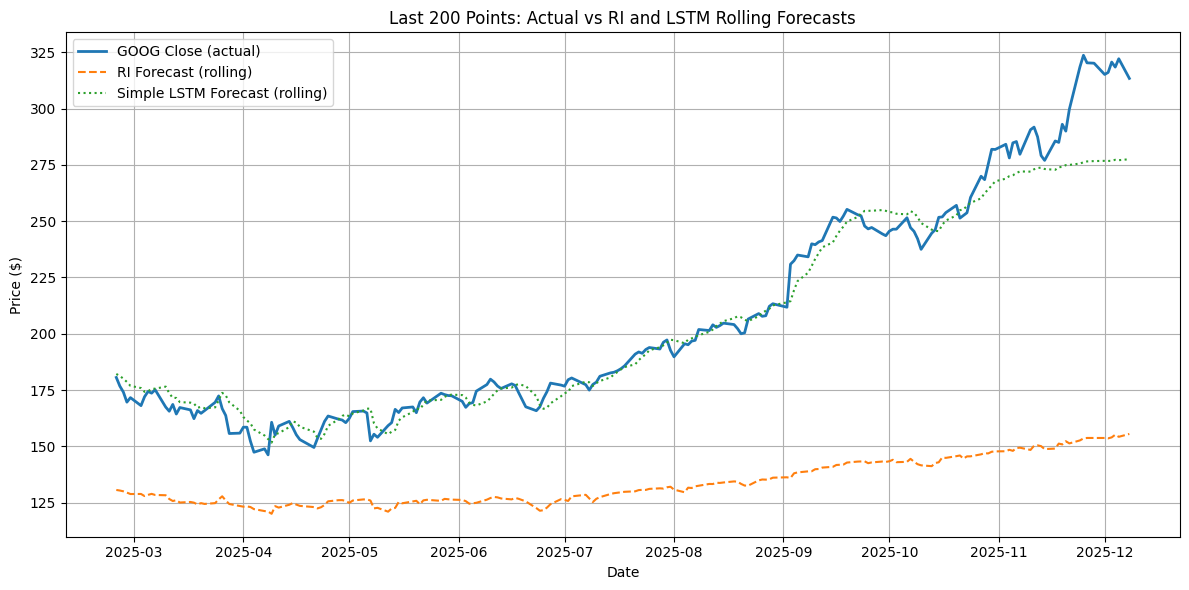

In [ ]:
# MULTI-STEP: PREDICT ENTIRE SERIES (1-STEP AHEAD ROLLING)
encoder.eval()
f_head.eval()
lstm_model.eval()

ri_preds = []
lstm_preds = []
idx_list = []

with torch.no_grad():
    # i is the index of the point we're predicting (uses previous context_len points)
    for i in range(context_len, len(X_norm)):
        ctx = X_norm[i - context_len : i]        # (C, D)
        ctx_t = torch.from_numpy(ctx).float().unsqueeze(0).to(device)  # (1, C, D)

        # RI prediction
        h = encoder(ctx_t)
        y_ri_norm = f_head(h).cpu().item()

        # LSTM prediction
        y_lstm_norm = lstm_model(ctx_t).cpu().item()

        ri_preds.append(y_ri_norm)
        lstm_preds.append(y_lstm_norm)
        idx_list.append(df.index[i])   # this prediction is for time i

# convert to real dollar prices
ri_preds = np.array(ri_preds) * stds[0] + means[0]
lstm_preds = np.array(lstm_preds) * stds[0] + means[0]
actual = df["Close"].iloc[context_len:].values
idx_all = pd.Index(idx_list)

#PLOT LAST 200 days (ACTUAL vs BOTH MODELS)
last_n = 200
idx_last = idx_all[-last_n:]

actual_last = actual[-last_n:]
ri_last = ri_preds[-last_n:]
lstm_last = lstm_preds[-last_n:]

plt.figure(figsize=(12, 6))

plt.plot(idx_last, actual_last, label="GOOG Close (actual)", linewidth=2)
plt.plot(idx_last, ri_last, label="RI Forecast (rolling)", linestyle="--")
plt.plot(idx_last, lstm_last, label="Simple LSTM Forecast (rolling)", linestyle=":")

plt.title("Last 200 Points: Actual vs RI and LSTM Rolling Forecasts")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
